In [1]:
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

import cv2
import matplotlib.pyplot as plt
import open3d as o3d

import os
import random
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
images = []
num_samples = 1


pathToImage = "C:/WorkingSets/3D/Images/0.jpg"
input_img = cv2.imread(pathToImage)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
images.append(input_img)


'''
for i in range(num_samples):
    pathToImage = "C:/WorkingSets/3D/Images/"+str(i)+".jpg"
    input_img = cv2.imread(pathToImage)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    #print(input_img.shape)

    images.append(input_img)
'''


'\nfor i in range(num_samples):\n    pathToImage = "C:/WorkingSets/3D/Images/"+str(i)+".jpg"\n    input_img = cv2.imread(pathToImage)\n    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)\n    #print(input_img.shape)\n\n    images.append(input_img)\n'

In [3]:
processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf").to("cuda")

print(model.config)

c:\Users\Juhász\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DepthAnythingConfig {
  "_commit_hash": "27ccb0920352c0c37b3a96441873c8d37bd52fb6",
  "_name_or_path": "LiheYoung/depth-anything-large-hf",
  "architectures": [
    "DepthAnythingForDepthEstimation"
  ],
  "backbone": null,
  "backbone_config": {
    "architectures": [
      "Dinov2Model"
    ],
    "hidden_size": 1024,
    "image_size": 518,
    "model_type": "dinov2",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "out_features": [
      "stage21",
      "stage22",
      "stage23",
      "stage24"
    ],
    "out_indices": [
      21,
      22,
      23,
      24
    ],
    "patch_size": 14,
    "reshape_hidden_states": false,
    "stage_names": [
      "stem",
      "stage1",
      "stage2",
      "stage3",
      "stage4",
      "stage5",
      "stage6",
      "stage7",
      "stage8",
      "stage9",
      "stage10",
      "stage11",
      "stage12",
      "stage13",
      "stage14",
      "stage15",
      "stage16",
      "stage17",
      "stage18",
      "stage19

In [4]:
samples=[]

for i in range(num_samples):
    input = processor(images=images[i], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model(**input)
        depth = outputs.predicted_depth
    
    depth = depth.squeeze().cpu().numpy()

    samples.append([images[i], depth])

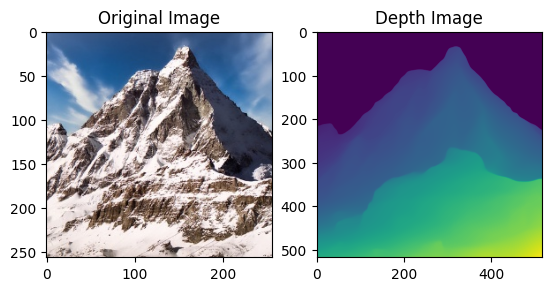

In [5]:
for i in range(num_samples):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(samples[i][0])
    axs[0].set_title("Original Image")
    axs[1].imshow(samples[i][1])
    axs[1].set_title("Depth Image")
    plt.show()

In [6]:
def get_intrinsics(H, W, fov = 55.0):
    '''
    Intrinsics for a pinhole camera model
    Assume fov of 55 degrees and central principal point
    '''

    f = 0.5 * W / np.tan(0.5 * fov * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

In [7]:
def pixel_to_point (depth_image, camera_intrinsics=None):
    '''
    Convert depth image to 3D points
    Assume fov of 55 degrees
    '''

    height, width = depth_image.shape
    if (camera_intrinsics is None):
        camera_intrinsics = get_intrinsics(height, width, fov=55.0)
    
    #Create u, v meshgrid and precompute projection triangle ratios
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height -1, height)
    u, v = np.meshgrid(x, y)

    x_over_z = (u - cx) / (fx)
    y_over_z = (v - cy) / (fy)

    #3-D pythagoras re-arranged for z
    z = depth_image / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z
    
    return x, y, z

In [8]:
def create_point_cloud(depth_image, color_image, camera_intrinsics=None, scale_ratio=100.0):

    height, width = depth_image.shape
    if (camera_intrinsics is None):
        camera_intrinsics = get_intrinsics(height, width, fov=55.0)
    
    color_image = cv2.resize(color_image, (width, height))

    #make sure that depth_image does not contain any zeros
    depth_image = np.maximum(depth_image, 1e-5)

    depth_image = scale_ratio / depth_image

    x, y, z = pixel_to_point(depth_image, camera_intrinsics)
    point_image = np.stack((x, y, z), axis=-1)

    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(point_image.reshape(-1, 3))
    cloud.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)

    #Masking for outdoor skies
    #mask = point_image[:,:,2] < 1e3
    #cloud.points = o3d.utility.Vector3dVector(point_image[mask].reshape(-1, 3))
    #cloud.points = o3d.utility.Vector3dVector(color_image[mask].reshape(-1, 3) / 255.0)

    return cloud

def create_points(depth_image, color_image, camera_intrinsics=None, scale_ratio=100.0):

    height, width = depth_image.shape
    if (camera_intrinsics is None):
        camera_intrinsics = get_intrinsics(height, width, fov=55.0)
    
    color_image = cv2.resize(color_image, (width, height))

    #make sure that depth_image does not contain any zeros
    depth_image = np.maximum(depth_image, 1e-5)

    depth_image = scale_ratio / depth_image

    x, y, z = pixel_to_point(depth_image, camera_intrinsics)
    point_image = np.stack((x, y, z), axis=-1)
    
    return point_image.reshape(-1, 3), color_image.reshape(-1, 3) / 255.0

In [9]:
output_path = "C:/WorkingSets/3D/Clouds/"
os.makedirs(output_path, exist_ok=True)

for i in range(num_samples):
    cloud = create_point_cloud(samples[i][1], samples[i][0])
    o3d.io.write_point_cloud(output_path + f"point_cloud_{i}.ply", cloud)

Visualizing the basic point cloud:

In [ ]:
import time

# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=750, width=750)


i = 0
depth_image = samples[i][1]
color_image = samples[i][0]

width, height = depth_image.shape

depth_image = (depth_image * 255 / np.max((depth_image))).astype('uint8')
color_image = cv2.resize(color_image, (width, height))

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(color_image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)


custom_intrinsic = get_intrinsics(height, width, 100) 
fx, fy = custom_intrinsic[0, 0], custom_intrinsic[1, 1]
cx, cy = custom_intrinsic[0, 2], custom_intrinsic[1, 2]
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
print("shape: ", np.asarray(pcd.points).shape)

reflected_points = np.asarray(pcd.points)
#reflected_points[:,0] *= -1
print("first point: ", reflected_points[0,:])
test = o3d.utility.Vector3dVector(reflected_points)
#pcd_raw.points.extend(test)
#pcd_raw.colors.extend(pcd_raw.colors)
pcd.points.append(np.array([3e-06, -1.25e-05, 1e-05]))
pcd.colors.append(np.array([0, 0, 255]))

#print(pcd.get_center)
#pcd_raw.colors.ext(np.array([0, 0, 255]))
#o3d.visualization.draw_geometries([pcd_raw])

#o3d.visualization.draw_geometries([pcd_raw, create_point_cloud(depth_image, color_image, custom_intrinsic)])



# include it in the visualizer before non-blocking visualization.
vis.add_geometry(pcd)

previous_t = time.time()
# to add new points each dt secs.
dt = 1

add = 0
# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    
    if time.time() - previous_t > dt:

        add += 1
        # Options (uncomment each to try them out):
        # 1) extend with ndarrays.
        #pcd.points.extend(np.random.rand(n_new, 3))
        
        # 2) extend with Vector3dVector instances.
        # pcd.points.extend(
        #     o3d.utility.Vector3dVector(np.random.rand(n_new, 3)))
        
        # 3) other iterables, e.g
        # pcd.points.extend(np.random.rand(n_new, 3).tolist())
        pointToAdd = reflected_points[0,:]
        print("point shpae:", pointToAdd.shape)
        #pointToAdd[1][2] += add
        pcd.points.extend(pointToAdd)
        print("add: ", add)

        vis.update_geometry(pcd)
        previous_t = time.time()

    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()


shape:  (193341, 3)
first point:  [ 2.92322028e-06 -1.21259508e-05  1.17647060e-05]


: 

Trying to fit distribution to point cloud:

In [ ]:
from scipy.stats import norm
np.random.seed(1)

X_plot = np.linspace(-10000000, 10000000, 1000)
fig, ax = plt.subplots(figsize=(5, 5))

i=0
points, colors = create_points(samples[i][1], samples[i][0])
print("# of 3D points:", points.shape[0])


def estimate_gaussian_mle(points, X_plot, plot=True):
    # Now, we estimate with MLE in close form
    mu_mle = points.mean()
    std_mle = np.std(points, ddof=0)
    if plot:
        MLE_dens = norm(mu_mle, std_mle).pdf(X_plot)
        _ = ax.fill(X_plot, MLE_dens, fc="red",
                    alpha=0.2, label="estimated")
    return mu_mle, std_mle


mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle})')

points shape :  (268324, 3)
colX shape:  (268324, 3)


(-5000000.0, 5000000.0)

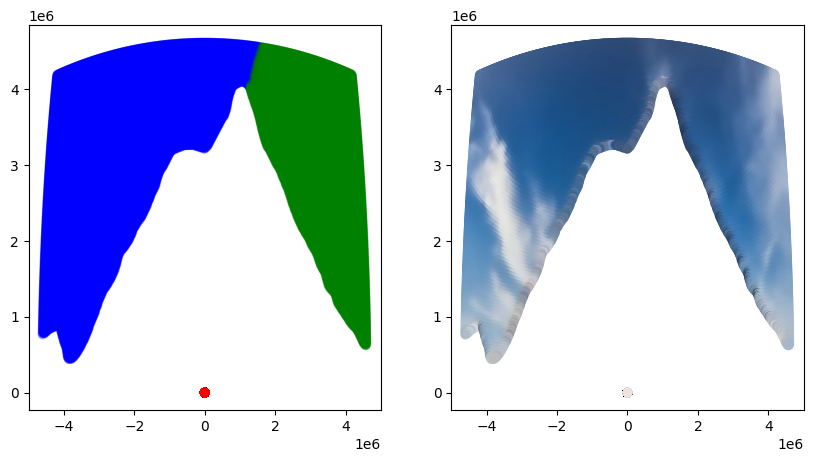

In [15]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
np.random.seed(1)

i=0
X, colX = create_points(samples[i][1], samples[i][0])
#print("points shape: ", X.shape)
print("points shape : ", X.shape)
print("colX shape: ", colX.shape)
#print(colX[...,0])

# X is 3xN
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)
# >>> gm.means_ #Dxk
assignments = gmm.predict(X)

X_plot = np.linspace(-5000000, 5000000, 1000)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


z_to_col = {0: 'red', 1: 'green', 2: 'blue'}
axs[0].scatter(X[..., 0], -X[..., 1], color=[z_to_col[y] for y in assignments], alpha=0.25)
axs[0].set_xlim(X_plot.min(), X_plot.max())  # Set x-axis limits to match X_plot

# Plot second scatter plot
axs[1].scatter(X[..., 0], -X[..., 1], color=[colX[y, ...] for y in range(colX.shape[0])], alpha=0.75)
axs[1].set_xlim(X_plot.min(), X_plot.max())  # Set x-axis limits to match

In [28]:
import open3d as o3d
import numpy as np
import time


# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

# initialize pointcloud instance.
pcd = o3d.geometry.PointCloud()
# *optionally* add initial points
points = np.random.rand(10, 3)
pcd.points = o3d.utility.Vector3dVector(points)

# include it in the visualizer before non-blocking visualization.
vis.add_geometry(pcd)

# to add new points each dt secs.
dt = 0.01
# number of points that will be added
n_new = 10

previous_t = time.time()

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    
    if time.time() - previous_t > dt:
        # Options (uncomment each to try them out):
        # 1) extend with ndarrays.
        pcd.points.extend(np.random.rand(n_new, 3))
        
        # 2) extend with Vector3dVector instances.
        # pcd.points.extend(
        #     o3d.utility.Vector3dVector(np.random.rand(n_new, 3)))
        
        # 3) other iterables, e.g
        # pcd.points.extend(np.random.rand(n_new, 3).tolist())
        
        vis.update_geometry(pcd)
        previous_t = time.time()

    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()
